# Intermodel comparison for  DSW export

In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import gsw
from pathlib import Path

import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.path as mpath
from IPython.display import display, Image

import netCDF4 as nc
import xarray as xr
import numpy as np
import xgcm
import calendar

from matplotlib import gridspec
from collections import OrderedDict

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45755,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:36675,Total threads: 1
Dashboard: /proxy/45567/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:44973,


### Loading the data 

In [4]:
# Importing data
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))
pathsM = np.sort(glob.glob('/scratch/x77/jn8053/mom6/archive/panant-01-zstar-ssp126-prsc-rest/*/*.ocean_month_z.nc'))

In [5]:
# Time variant variables
def preprocess(ds):
    ds = ds[['uo','vo','agessc','so']] # Picking out variables get all grids
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [6]:
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

#### New Method

In [7]:
# Contour mask
isobath_depth = 1000
outfile = '/g/data/x77/cy8964/Post_Process/access-om2'+'/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
contour_mask_2 = np.load(outfile)
contour_mask_1 = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')

In [8]:
lat_slice = slice(-79,-59)
grid_pan = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')
grid_acc = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')

In [9]:
# --- Grids and masks ---
grids = {'panant': grid_pan, 'access': grid_acc}
masks = {'panant': contour_mask_1, 'access': contour_mask_2}

# --- Dictionary to store results ---
contour_data = {}

for res in ['panant', 'access']:
    grid = grids[res]
    contour_mask = masks[res]

    if res == 'panant':
        # ----- PanAnt -----
        yh = grid['yh'].sel(yh=lat_slice)
        yq = grid['yq'].sel(yq=lat_slice)
        xh = grid['xh']
        xq = grid['xq']

        # Select masks for this lat slice
        mask_y_transport = contour_mask['mask_y_transport'].sel(yq=lat_slice)
        mask_x_transport = contour_mask['mask_x_transport'].sel(yh=lat_slice)
        mask_y_transport_numbered = contour_mask['mask_y_transport_numbered'].sel(yq=lat_slice)
        mask_x_transport_numbered = contour_mask['mask_x_transport_numbered'].sel(yh=lat_slice)

        # Assign coordinates (same as your original)
        mask_x_transport = xr.DataArray(mask_x_transport,
            coords=[yh[:mask_x_transport.shape[0]], xq[:mask_x_transport.shape[1]]],
            dims=['y_ocean', 'x_ocean'])
        mask_y_transport = xr.DataArray(mask_y_transport,
            coords=[yq[:mask_y_transport.shape[0]], xh[:mask_y_transport.shape[1]]],
            dims=['y_ocean', 'x_ocean'])
        mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered,
            coords=[yh[:mask_x_transport_numbered.shape[0]], xq[:mask_x_transport_numbered.shape[1]]],
            dims=['y_ocean', 'x_ocean'])
        mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered,
            coords=[yq[:mask_y_transport_numbered.shape[0]], xh[:mask_y_transport_numbered.shape[1]]],
            dims=['y_ocean', 'x_ocean'])

    else:
        
        # ----- ACCESS -----
        # Load masks from .npz (numpy arrays)
        mask_y_transport = contour_mask['mask_y_transport']
        mask_x_transport = contour_mask['mask_x_transport']
        mask_y_transport_numbered = contour_mask['mask_y_transport_numbered']
        mask_x_transport_numbered = contour_mask['mask_x_transport_numbered']
    
        # Now get correct coordinate sizes
        yt_ocean = grid['yt_ocean'][:mask_x_transport.shape[0]]
        yu_ocean = grid['yu_ocean'][:mask_y_transport.shape[0]]
        xt_ocean = grid['xt_ocean'][:mask_y_transport.shape[1]]
        xu_ocean = grid['xu_ocean'][:mask_x_transport.shape[1]]
    
        # Build DataArrays (exactly as in your original code)
        mask_x_transport = xr.DataArray(mask_x_transport,
            coords=[yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
        mask_y_transport = xr.DataArray(mask_y_transport,
            coords=[yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])
        mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered,
            coords=[yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
        mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered,
            coords=[yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])

    # --- Stack contour data into 1D (shared logic) ---
    mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index=['y_ocean', 'x_ocean'])
    mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop=True)
    mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index=['y_ocean', 'x_ocean'])
    mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop=True)

    contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim='contour_index')
    contour_ordering = contour_ordering.sortby(contour_ordering)
    contour_index_array = np.arange(1, len(contour_ordering) + 1)

    # --- Get lat/lon along contour ---
    lat_along_contour = contour_ordering.y_ocean
    lon_along_contour = contour_ordering.x_ocean
    lat_along_contour.coords['contour_index'] = contour_index_array
    lon_along_contour.coords['contour_index'] = contour_index_array

    # --- Save results ---
    contour_data[res] = {
        'lat': lat_along_contour,
        'lon': lon_along_contour,
        'contour_index': contour_index_array
    }


In [10]:
# Dictionary to store tickmark indices for both resolutions
distance_indices_all = {}

for res in ['panant', 'access']:
    lon_along_contour = contour_data[res]['lon']

    distance_indices = np.zeros(8, dtype=int)
    for i in np.arange(100, len(lon_along_contour.values)):
        if distance_indices[1] == 0 and lon_along_contour.values[i] > -240:
            distance_indices[1] = lon_along_contour.contour_index.values[i]
        if distance_indices[2] == 0 and lon_along_contour.values[i] > -180:
            distance_indices[2] = lon_along_contour.contour_index.values[i]
        if distance_indices[3] == 0 and lon_along_contour.values[i] > -120:
            distance_indices[3] = lon_along_contour.contour_index.values[i]
        if distance_indices[4] == 0 and lon_along_contour.values[i] > -60:
            distance_indices[4] = lon_along_contour.contour_index.values[i]
        if distance_indices[5] == 0 and lon_along_contour.values[i] > 0:
            distance_indices[5] = lon_along_contour.contour_index.values[i]
        if distance_indices[6] == 0 and lon_along_contour.values[i] > 60:
            distance_indices[6] = lon_along_contour.contour_index.values[i]

    distance_indices[7] = len(lon_along_contour.contour_index.values) - 1

    # Save for this resolution
    distance_indices_all[res] = distance_indices

In [11]:
# Define in longitude space what the cut-off values for regions should be.
AdelieW = -280
AdelieE = -200
RossW = -200
RossE = -150
# WAW = -150
# WAE = -65
AmW = -150
AmE = -100
BeW = -100
BeE = -65

WeddellW = -65
WeddellE = 0
PrydzW = 0
PrydzE = 80

In [12]:
# Dictionary to store basin indices for both resolutions
basin_indices_all = {}

# Define basin longitude thresholds (already defined in your script)
# AdelieE, RossE, AmE, BeE, WeddellE, PrydzE

for res in ['panant', 'access']:
    lon_along_contour = contour_data[res]['lon']

    basin_indices = np.zeros(7, dtype=int)
    for i in np.arange(100, len(lon_along_contour.values)):
        if basin_indices[1] == 0 and lon_along_contour.values[i] > AdelieE:
            basin_indices[1] = lon_along_contour.contour_index.values[i]
        if basin_indices[2] == 0 and lon_along_contour.values[i] > RossE:
            basin_indices[2] = lon_along_contour.contour_index.values[i]
        if basin_indices[3] == 0 and lon_along_contour.values[i] > AmE:
            basin_indices[3] = lon_along_contour.contour_index.values[i]
        if basin_indices[4] == 0 and lon_along_contour.values[i] > BeE:
            basin_indices[4] = lon_along_contour.contour_index.values[i]
        if basin_indices[5] == 0 and lon_along_contour.values[i] > WeddellE:
            basin_indices[5] = lon_along_contour.contour_index.values[i]
        if basin_indices[6] == 0 and lon_along_contour.values[i] > PrydzE:
            basin_indices[6] = lon_along_contour.contour_index.values[i]

    # Save for this resolution
    basin_indices_all[res] = basin_indices


In [13]:
# If already loaded, just use:
distance_along_contour_pan = xr.open_dataset('/g/data/x77/kc5856/Post_Process/panan-01/1000m_isobath_contour_distance.nc').distance_along_contour
distance_along_contour_acc = xr.open_dataset('/g/data/x77/cy8964/Post_Process/access-om2/1000m_isobath_contour_distance.nc').distance_along_contour

In [14]:
Adelie = slice(basin_indices[0],basin_indices[1])
Ross = slice(basin_indices[1],basin_indices[2])
Am = slice(basin_indices[2],basin_indices[3])
Be = slice(basin_indices[3],basin_indices[4])
Weddell = slice(basin_indices[4], basin_indices[5])
Prydz = slice(basin_indices[5],6080)

## Plotting

In [15]:
land_mask = np.squeeze(grid_pan['deptho'].values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

# make land go all the way to -90S:
land_mask_lat = grid_pan['deptho'].yh.values
land_mask_lat[0] = -90

In [16]:
save_dir = '/g/data/x77/kc5856/sofia-cross_slope_transport/cross_slope_binned/'

deptho = grid_pan['deptho'].sel(yh=lat_slice)
yh = grid_pan['yh'].sel(yh=lat_slice)
xh = grid_pan['xh']

In [17]:
file_dir = '/g/data/x77/kc5856/sofia-cross_slope_transport/plots/'

In [18]:
panant_cont_circ = xr.open_dataset(file_dir+'Circumpolar_Control_pan01_transport_profile.nc').to_array().squeeze()
panant_cont_Ade = xr.open_dataset(file_dir+'Adelie_Control_pan01_transport_profile.nc').to_array().squeeze()
panant_cont_Ros = xr.open_dataset(file_dir+'Ross_Control_pan01_transport_profile.nc').to_array().squeeze()
panant_cont_Am = xr.open_dataset(file_dir+'Amundsen_Control_pan01_transport_profile.nc').to_array().squeeze()
panant_cont_Be = xr.open_dataset(file_dir+'Bellingshausen_Control_pan01_transport_profile.nc').to_array().squeeze()
panant_cont_We = xr.open_dataset(file_dir+'Weddell_Control_pan01_transport_profile.nc').to_array().squeeze()
panant_cont_Pr = xr.open_dataset(file_dir+'Prydz_Control_pan01_transport_profile.nc').to_array().squeeze()

panant_melt_circ = xr.open_dataset(file_dir+'Circumpolar_Melt_prescribed_pan01_transport_profile.nc').to_array().squeeze()
panant_melt_Ade = xr.open_dataset(file_dir+'Adelie_Melt_prescribed_pan01_transport_profile.nc').to_array().squeeze()
panant_melt_Ros = xr.open_dataset(file_dir+'Ross_Melt_prescribed_pan01_transport_profile.nc').to_array().squeeze()
panant_melt_Am = xr.open_dataset(file_dir+'Amundsen_Melt_prescribed_pan01_transport_profile.nc').to_array().squeeze()
panant_melt_Be = xr.open_dataset(file_dir+'Bellingshausen_Melt_prescribed_pan01_transport_profile.nc').to_array().squeeze()
panant_melt_We = xr.open_dataset(file_dir+'Weddell_Melt_prescribed_pan01_transport_profile.nc').to_array().squeeze()
panant_melt_Pr = xr.open_dataset(file_dir+'Prydz_Melt_prescribed_pan01_transport_profile.nc').to_array().squeeze()

In [19]:
access_cont_circ = xr.open_dataset(file_dir+'Circumpolar_Control_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_cont_Ade = xr.open_dataset(file_dir+'Adelie_Control_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_cont_Ros = xr.open_dataset(file_dir+'Ross_Control_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_cont_Am = xr.open_dataset(file_dir+'Amundsen_Control_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_cont_Be = xr.open_dataset(file_dir+'Bellingshausen_Control_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_cont_We = xr.open_dataset(file_dir+'Weddell_Control_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_cont_Pr = xr.open_dataset(file_dir+'Prydz_Control_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()

access_melt_circ = xr.open_dataset(file_dir+'Circumpolar_Melt_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_melt_Ade = xr.open_dataset(file_dir+'Adelie_Melt_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_melt_Ros = xr.open_dataset(file_dir+'Ross_Melt_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_melt_Am = xr.open_dataset(file_dir+'Amundsen_Melt_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_melt_Be = xr.open_dataset(file_dir+'Bellingshausen_Melt_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_melt_We = xr.open_dataset(file_dir+'Weddell_Melt_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()
access_melt_Pr = xr.open_dataset(file_dir+'Prydz_Melt_prescribed_ACCESS_transport_profile.nc').to_array().squeeze()

In [20]:
panant_anom_circ = panant_melt_circ - panant_cont_circ
panant_anom_Ade = panant_melt_Ade - panant_cont_Ade
panant_anom_Ros = panant_melt_Ros - panant_cont_Ros
panant_anom_Am = panant_melt_Am - panant_cont_Am
panant_anom_Be = panant_melt_Be - panant_cont_Be
panant_anom_We = panant_melt_We - panant_cont_We
panant_anom_Pr = panant_melt_Pr - panant_cont_Pr

In [21]:
access_anom_circ = access_melt_circ - access_cont_circ
access_anom_Ade = access_melt_Ade - access_cont_Ade
access_anom_Ros = access_melt_Ros - access_cont_Ros
access_anom_Am = access_melt_Am - access_cont_Am
access_anom_Be = access_melt_Be - access_cont_Be
access_anom_We = access_melt_We - access_cont_We
access_anom_Pr = access_melt_Pr - access_cont_Pr

In [87]:
# Cumulative sums
panant_cont_cumsum = xr.open_dataset(file_dir+'Control_prescribed_pan01_cumulative_transport.nc')['Control_cumulative_transport']
panant_melt_cumsum = xr.open_dataset(file_dir+'Melt_prescribed_pan01_cumulative_transport.nc')['Melt_cumulative_transport']
panant_anom_cumsum = panant_melt_cumsum - panant_cont_cumsum

access_cont_cumsum = xr.open_dataset(file_dir+'Control_prescribed_ACCESS_cumulative_transport.nc')['Control_cumulative_transport']
access_melt_cumsum = xr.open_dataset(file_dir+'Melt_prescribed_ACCESS_cumulative_transport.nc')['Melt_cumulative_transport']
access_anom_cumsum = access_melt_cumsum - access_cont_cumsum

In [88]:
# --- Colors and line styles ---
colors = {
    'control': 'k', 
    'melt': '#BB5566',
    'anom_pan': '#0072B2', 
    'anom_acc': '#D55E00',
    'panant': '#0072B2',
    'access': '#D55E00'
}

linestyles = {
    'control': '--', 
    'melt': '-', 
    'anom_pan': '-', 
    'anom_acc': '-',
    'panant': '-',
    'access':'-',
    'Control_panant': '-',
    'Control_access': '-'
}
linewidths = {k: 2 for k in colors.keys()}
labels = {
    'control': 'Control', 
    'melt': 'Melt', 
    'anom_pan': 'PanAnt.', 
    'anom_acc': 'ACCESS-OM2',
    'panant':'PanAnt.',
    'access':'ACCESS-OM2',
    'Control_panant': 'PanAnt.',
    'Control_access': 'ACCESS-OM2'
}


# --- Sector names and letters (removed Amundsen + Bellingshausen) ---
sector_names = ['Circumpolar', 'Adelie', 'Ross', 'Weddell', 'Prydz']
letter_labels = ['a)', 'b)', 'c)', 'd)', 'e)']

# --- Data arrays (removed Am + Be entries) ---
sector_panant_control = [panant_cont_circ, panant_cont_Ade, panant_cont_Ros, panant_cont_We, panant_cont_Pr]
sector_panant_melt    = [panant_melt_circ, panant_melt_Ade, panant_melt_Ros, panant_melt_We, panant_melt_Pr]

sector_access_control = [access_cont_circ, access_cont_Ade, access_cont_Ros, access_cont_We, access_cont_Pr]
sector_access_melt    = [access_melt_circ, access_melt_Ade, access_melt_Ros, access_melt_We, access_melt_Pr]

sector_anoms_pan = [panant_anom_circ, panant_anom_Ade, panant_anom_Ros, panant_anom_We, panant_anom_Pr]
sector_anoms_acc = [access_anom_circ, access_anom_Ade, access_anom_Ros, access_anom_We, access_anom_Pr]

### Plots

In [89]:
# X-limits for control vs melt (rows 1 + 2)
xlims_ctrlmelt = {
    'Circumpolar': (-0.1, 8.6),
    'Adelie': (-2, 2),
    'Ross': (-0.1, 4.1),
    'Amundsen': (-0.4, 0.2),
    'Bellingshausen': (-0.3, 0.3),
    'Weddell': (-0.5, 3),
    'Prydz': (-0.1, 2.2)
}

# X-limits for anomalies (row 3)
xlims_anom = {
    'Circumpolar': (-1.6, 0.6),
    'Adelie': (-1, 0.2),
    'Ross': (-1.5, 0.2),
    'Amundsen': (-0.1, 0.1),
    'Bellingshausen': (-0.05, 0.4),
    'Weddell': (-1.5, 1.5),
    'Prydz': (-1, 0.5)
}

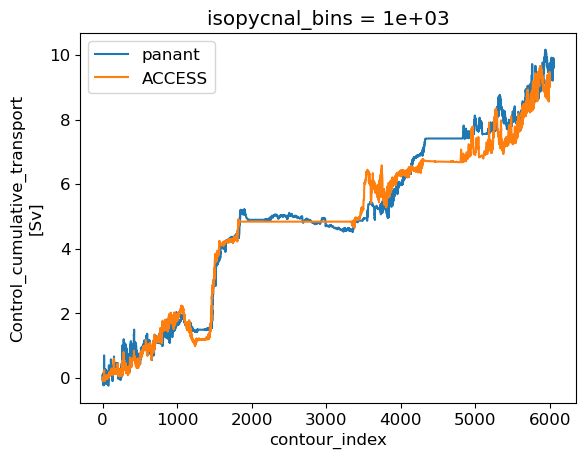

In [90]:
panant_cont_cumsum.plot(label = 'panant')
access_cont_cumsum.plot(label = 'ACCESS')
plt.legend()

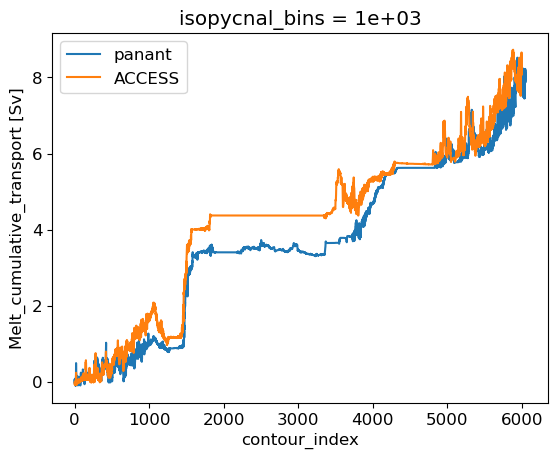

In [91]:
panant_melt_cumsum.plot(label = 'panant')
access_melt_cumsum.plot(label = 'ACCESS')
plt.legend()

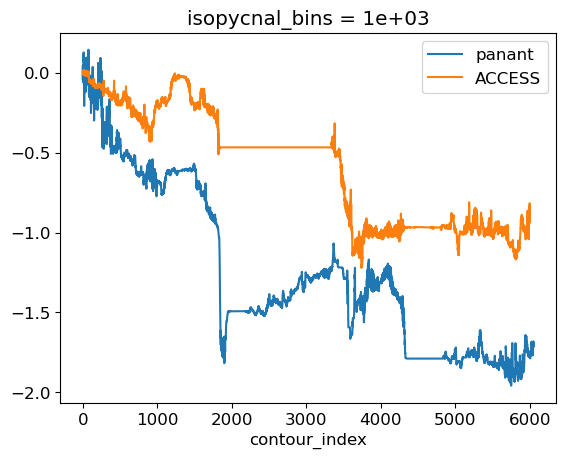

In [92]:
panant_anom_cumsum.plot(label = 'panant')
access_anom_cumsum.plot(label = 'ACCESS')
plt.legend()

In [93]:
# --- Sector names and letters ---
sector_names = ['Circumpolar', 'Adelie', 'Ross', 'Amundsen', 'Bellingshausen', 'Weddell', 'Prydz']
letter_labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)']

# --- Data arrays ---
sector_panant_control = [panant_cont_circ, panant_cont_Ade, panant_cont_Ros, panant_cont_Am,
                         panant_cont_Be, panant_cont_We, panant_cont_Pr]
sector_panant_melt    = [panant_melt_circ, panant_melt_Ade, panant_melt_Ros, panant_melt_Am,
                         panant_melt_Be, panant_melt_We, panant_melt_Pr]

sector_access_control = [access_cont_circ, access_cont_Ade, access_cont_Ros, access_cont_Am,
                         access_cont_Be, access_cont_We, access_cont_Pr]
sector_access_melt    = [access_melt_circ, access_melt_Ade, access_melt_Ros, access_melt_Am,
                         access_melt_Be, access_melt_We, access_melt_Pr]

sector_anoms_panant = [panant_anom_circ, panant_anom_Ade, panant_anom_Ros, panant_anom_Am,
                       panant_anom_Be, panant_anom_We, panant_anom_Pr]
sector_anoms_access = [access_anom_circ, access_anom_Ade, access_anom_Ros, access_anom_Am,
                       access_anom_Be, access_anom_We, access_anom_Pr]

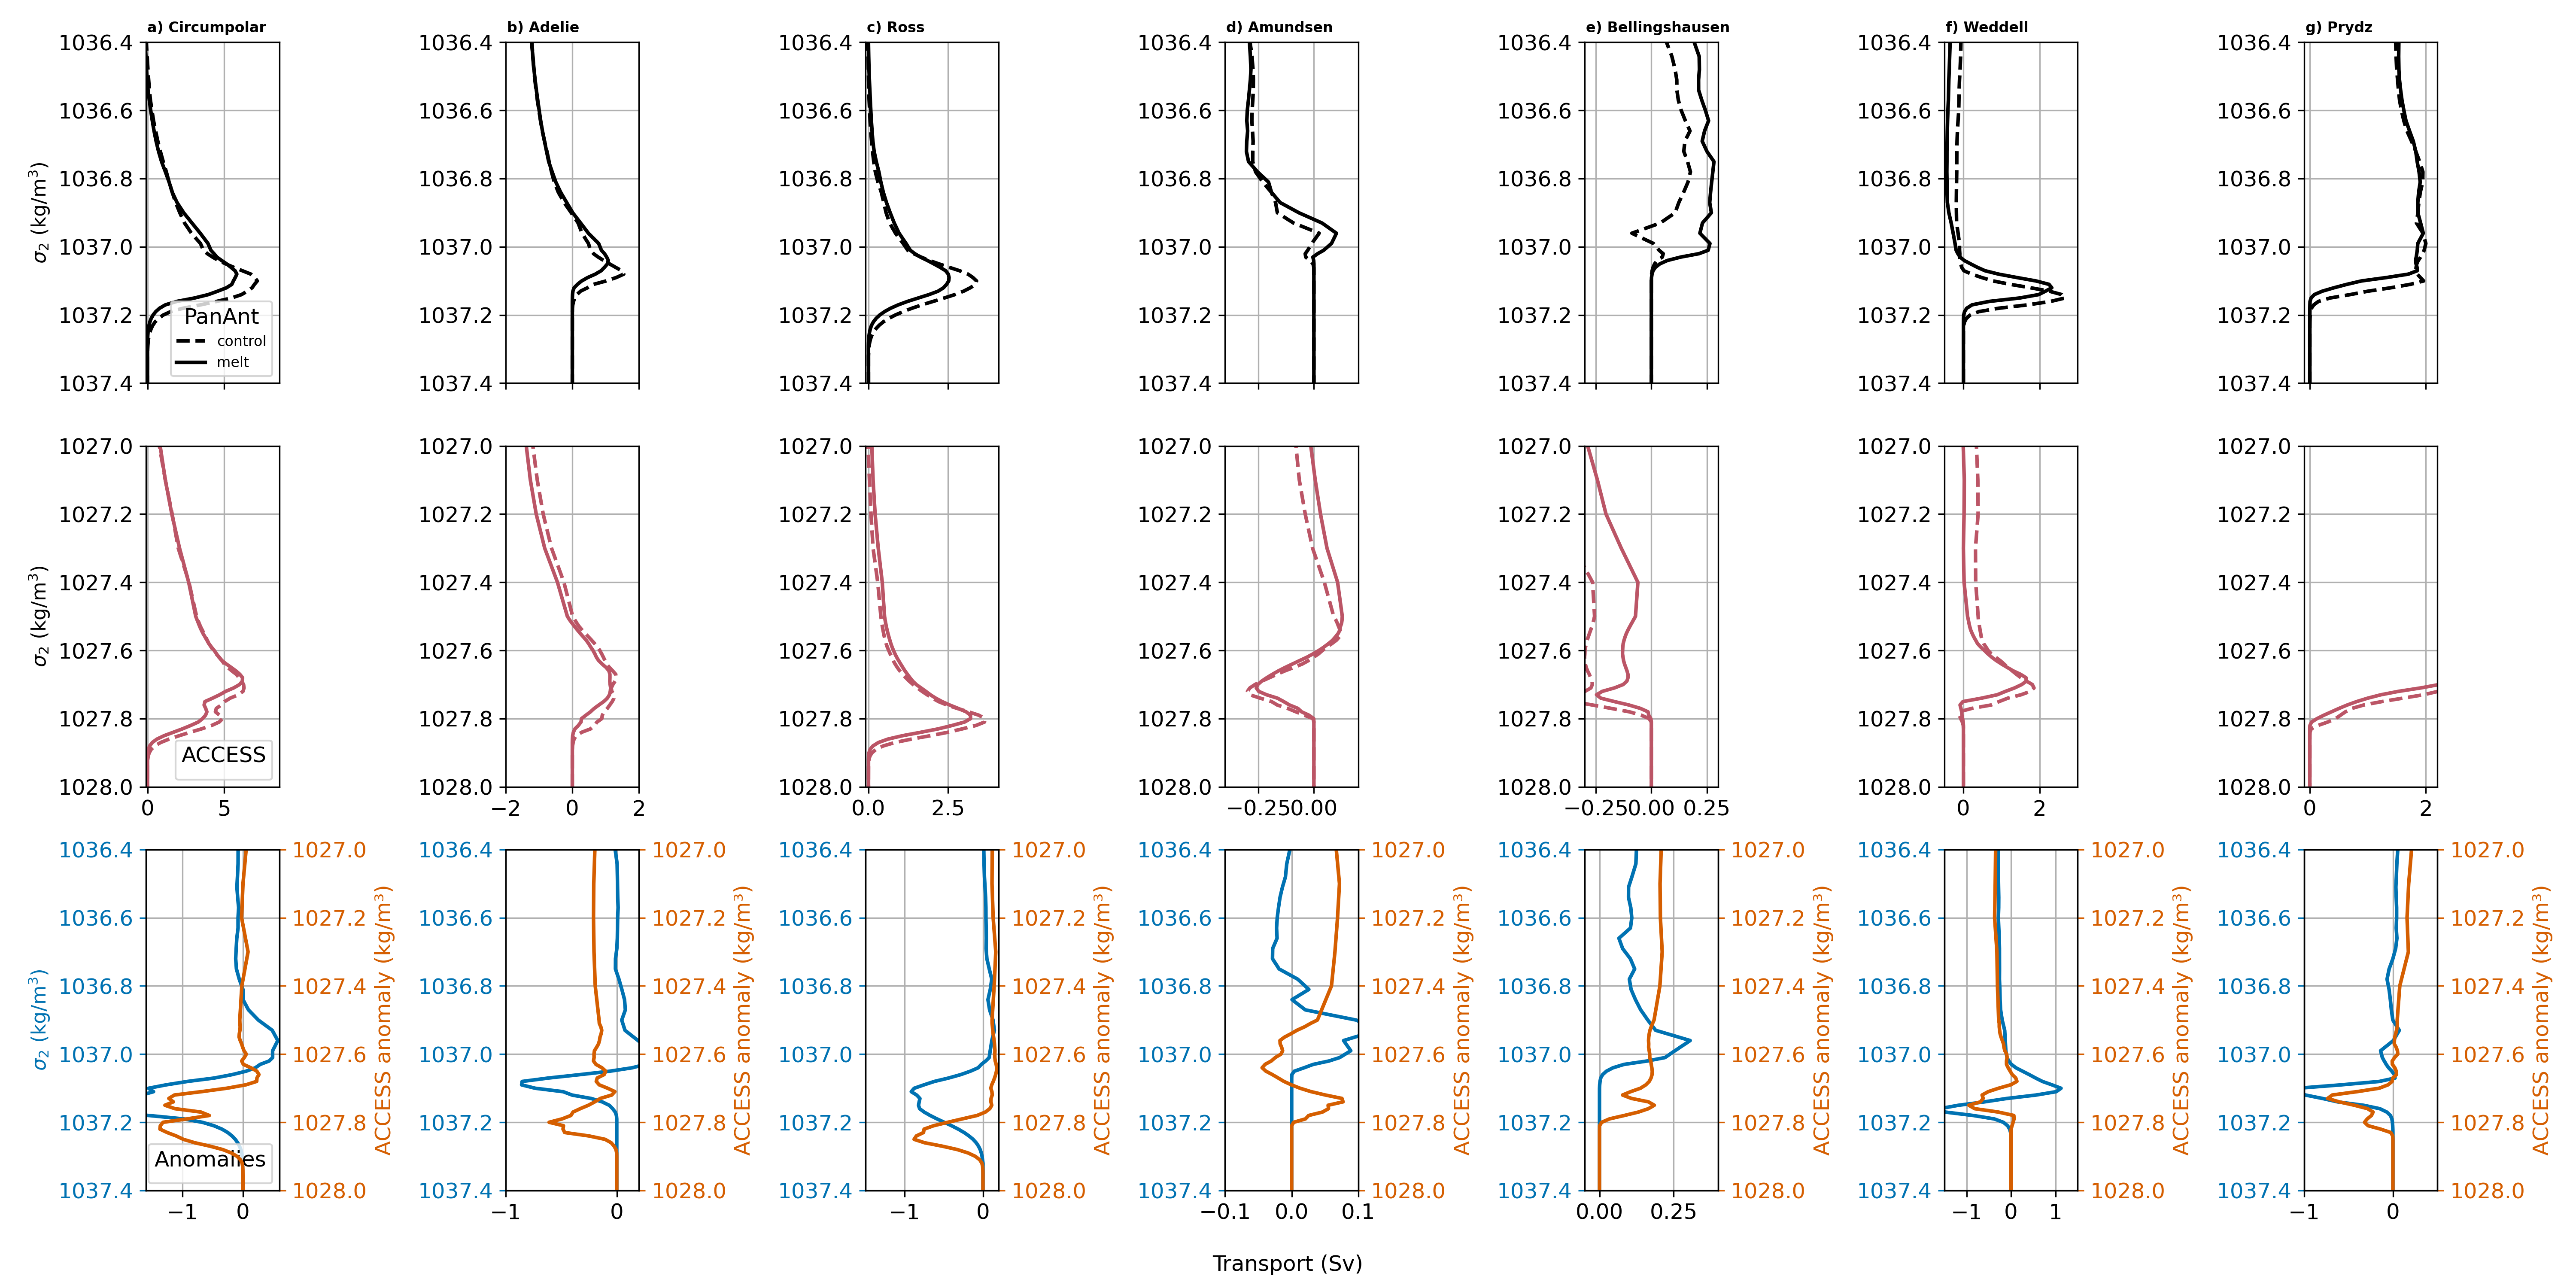

In [94]:
# --- Define figure ---
fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(20, 10), sharey=False)

# --- Loop rows/cols ---
for col, (name, letter) in enumerate(zip(sector_names, letter_labels)):

    # Row 1: panant (control vs melt)
    ax = axes[0, col]
    sector_panant_control[col].plot(ax=ax, y='rho2_l', color=colors['control'],
                                    linestyle='--', linewidth=linewidths['control'],
                                    label='control')
    sector_panant_melt[col].plot(ax=ax, y='rho2_l', color=colors['control'],
                                 linestyle='-', linewidth=linewidths['melt'],
                                 label='melt')
    ax.set_ylim(1037.4, 1036.4)
    ax.set_xlim(xlims_ctrlmelt[name])   # same for row 1 + 2
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.grid()
    ax.set_title('')   # remove auto-title
    ax.text(0.01, 1.03, f'{letter} {name}', transform=ax.transAxes, fontsize=8, fontweight='bold')

    # Row 2: access (control vs melt)
    ax = axes[1, col]
    sector_access_control[col].plot(ax=ax, y='isopycnal_bins', color=colors['melt'],
                                    linestyle='--', linewidth=linewidths['control'])
    sector_access_melt[col].plot(ax=ax, y='isopycnal_bins', color=colors['melt'],
                                 linestyle='-', linewidth=linewidths['melt'])
    ax.set_ylim(1028, 1027)
    ax.set_xlim(xlims_ctrlmelt[name])   # same for row 1 + 2
    plt.setp(ax.get_xticklabels(), visible=True)
    ax.grid()
    ax.set_title('')   # remove auto-title

    # Row 3: anomalies (panant vs access)
    ax = axes[2, col]

    # Plot PanAnt anomaly on left y-axis
    sector_anoms_panant[col].plot(ax=ax, y='rho2_l', color=colors['anom_pan'],
                                  linestyle=linestyles['anom_pan'], linewidth=linewidths['anom_pan'])
    ax.set_ylim(1037.4, 1036.4)  # PanAnt limits
    ax.set_xlim(xlims_anom[name])
    ax.set_ylabel('PanAnt anomaly (kg/m³)', color=colors['anom_pan'])
    ax.tick_params(axis='y', colors=colors['anom_pan'])
    
    # Create a second y-axis for ACCESS anomaly
    ax2 = ax.twinx()
    sector_anoms_access[col].plot(ax=ax2, y='isopycnal_bins', color=colors['anom_acc'],
                                  linestyle=linestyles['anom_acc'], linewidth=linewidths['anom_acc'])
    ax2.set_ylim(1028, 1027)  # ACCESS limits
    ax2.set_ylabel('ACCESS anomaly (kg/m³)', color=colors['anom_acc'])
    ax2.tick_params(axis='y', colors=colors['anom_acc'])
    
    # Optional: grid only on primary axis
    ax.grid(True)
    plt.setp(ax.get_xticklabels(), visible=True)
    ax.set_title('')

# --- Axis labels ---
for row, axrow in enumerate(axes):
    for col, ax in enumerate(axrow):
        if col == 0:
            ax.set_ylabel(r'$\sigma_2$ (kg/m$^3$)', fontsize=11)
        else:
            ax.set_ylabel('')

# --- Legends ---
axes[0, 0].legend(loc='lower right', fontsize=8, title="PanAnt")
axes[1, 0].legend(loc='lower right', fontsize=8, title="ACCESS")
axes[2, 0].legend(loc='lower right', fontsize=8, title="Anomalies")

fig.supxlabel("Transport (Sv)", fontsize=12)
fig.tight_layout()
fig.savefig("control_melt_anomaly_comparison_testintermodel.png", dpi=300)
plt.close(fig)
display(Image(filename="control_melt_anomaly_comparison_testintermodel.png", width=1200))


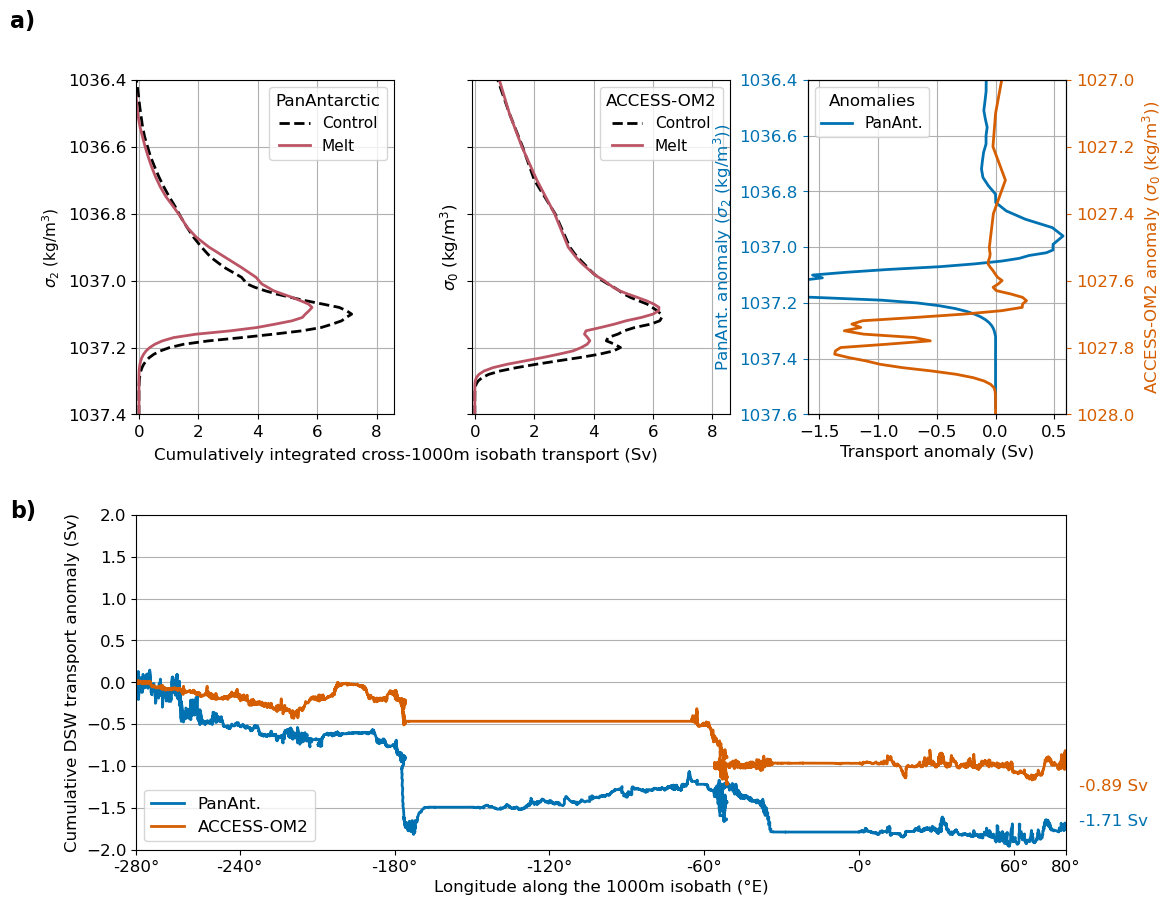

In [95]:
plt.rcParams['font.size'] = 12

# --- Define combined figure layout: 2 rows (top: 3 cols, bottom: 1 col full width) ---
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], hspace=0.3,wspace=0.3)

# Pick out Circumpolar only (col=0)
name = sector_names[0]       # "Circumpolar"
letter = letter_labels[0]    # "a)"

# =====================
# Top row: 3 panels
# =====================
# Panel 1: pan01 (control vs melt)
ax1 = fig.add_subplot(gs[0, 0])
sector_panant_control[0].plot(ax=ax1, y='rho2_l',
                             color=colors['control'], linestyle=linestyles['control'],
                             linewidth=linewidths['control'], label=labels['control'])
sector_panant_melt[0].plot(ax=ax1, y='rho2_l',
                          color=colors['melt'], linestyle=linestyles['melt'],
                          linewidth=linewidths['melt'], label=labels['melt'])
ax1.set_ylim(1037.4, 1036.4)
ax1.set_xlim(xlims_ctrlmelt[name])
ax1.grid()
ax1.set_ylabel(r'$\sigma_2$ (kg/m$^3$)', fontsize=11)
ax1.legend(loc='upper right', fontsize=11, title="PanAntarctic")
ax1.set_xlabel("")
ax1.set_title("")

# Panel 2: ACCESS (control vs melt)
ax2 = fig.add_subplot(gs[0, 1])
sector_access_control[0].plot(ax=ax2, y='isopycnal_bins',
                              color=colors['control'], linestyle=linestyles['control'],
                              linewidth=linewidths['control'], label=labels['control'])
sector_access_melt[0].plot(ax=ax2, y='isopycnal_bins',
                           color=colors['melt'], linestyle=linestyles['melt'],
                           linewidth=linewidths['melt'], label=labels['melt'])
ax2.set_ylim(1028, 1027)
ax2.set_xlim(xlims_ctrlmelt[name])
ax2.grid()
ax2.set_ylabel('$\sigma_0$ (kg/m$^3$)')
ax2.tick_params(labelleft=False)
ax2.legend(loc='upper right', fontsize=11, title="ACCESS-OM2")
ax2.set_xlabel("")
ax2.set_title("")

# --- Panel 3: anomalies ---
ax3 = fig.add_subplot(gs[0, 2])

# Left y-axis: PanAnt anomalies
sector_anoms_panant[0].plot(
    ax=ax3, y='rho2_l',
    color=colors['anom_pan'],
    linestyle=linestyles['anom_pan'],
    linewidth=linewidths['anom_pan'],
    label=labels['anom_pan']
)
ax3.set_ylim(1037.6, 1036.4)  # PanAnt y-lims
ax3.set_xlim(xlims_anom[name])
ax3.set_ylabel('PanAnt. anomaly ($\sigma_2$ (kg/m$^3$))', color=colors['anom_pan'])
ax3.tick_params(axis='y', colors=colors['anom_pan'])
ax3.grid()

# Right y-axis: ACCESS anomalies
ax3b = ax3.twinx()
sector_anoms_access[0].plot(
    ax=ax3b, y='isopycnal_bins',
    color=colors['anom_acc'],
    linestyle=linestyles['anom_acc'],
    linewidth=linewidths['anom_acc'],
    label=labels['anom_acc']
)
ax3b.set_ylim(1028, 1027)  # ACCESS y-lims
ax3b.set_ylabel('ACCESS-OM2 anomaly ($\sigma_0$ (kg/m$^3$))', color=colors['anom_acc'])
ax3b.tick_params(axis='y', colors=colors['anom_acc'])

# Shared x-axis setup
ax3.set_xlabel("Transport anomaly (Sv)", fontsize=12)

# Optional combined legend (use one legend only, e.g. from left axis)
ax3.legend(loc='upper left', fontsize=11, title="Anomalies")


# Shared xlabel for left & middle panels
fig.text(0.35, 0.5, "Cumulatively integrated cross-1000m isobath transport (Sv)",
         ha="center", fontsize=12)

# =====================
# Bottom row: 1 wide bar chart
# =====================

ax4 = fig.add_subplot(gs[1, :])  # span all 3 columns

# --- Plot each anomaly ---
for key, array, res in zip(
    ['panant', 'access'],
    [panant_anom_cumsum, access_anom_cumsum],
    ['panant', 'access']
):
    lon_vals = contour_data[res]['lon']

    # Optional offset for label placement
    offset = 0 if key == 'panant' else -0.4
    
    # Plot line
    ax4.plot(lon_vals, array, label=labels[key],
                color=colors[key], linestyle=linestyles[key], linewidth=2)
    
    # Add text at the end of the line
    ax4.text(lon_vals[-1] + 5, offset + array[-1],
             f"{array[-1].values:.2f} Sv", color=colors[key], fontsize=12)

# --- Customize axes ---
ax4.set_ylabel('Cumulative DSW transport anomaly (Sv)', fontsize=12)
ax4.set_ylim(-2, 2)  # adjust for anomaly scale
ax4.grid(axis='y')

# ✅ Use pan01 ticks/labels as reference
res_ref = 'panant'
indices = distance_indices_all[res_ref]
x_ticks = contour_data[res_ref]['lon'].values[indices]
ax4.set_xticks(x_ticks)
ax4.set_xticklabels([f"{lon:.0f}°" for lon in x_ticks])

ax4.set_xlabel('Longitude along the 1000m isobath (°E)', fontsize=12)
ax4.legend(loc='lower left', bbox_to_anchor=(0, 0), fontsize=12)

ax4.set_xlim(-280,80)

# === Panel labels ===
fig.text(0.02, 0.95, "a)", fontsize=16, fontweight='bold', va="top", ha="left")
fig.text(0.02, 0.46, "b)", fontsize=16, fontweight='bold', va="top", ha="left")

# =====================
# Final layout
# =====================
plt.tight_layout()
fig.savefig("/g/data/g40/kc5856/thesis_figures/intermodel_DSWexport_combined_alonglon_1.png",
            dpi=300, bbox_inches='tight')
plt.show()

# Net transport

In [99]:
# Cumulative transport in ax7
slices_pan = {
    'Ade': slice(1037.08,1037.4),
    'Ros': slice(1037.11,1037.4),
    'AmBe': slice(1036.96,1037.4),
    'We': slice(1037.15,1037.4),
    'Pr': slice(1036.97,1037.4),
}

slices_acc = {
    'Ade': slice(1027.71, 1028),
    'Ros': slice(1027.80, 1028),
    'AmBe': slice(1027.83, 1028),
    'We': slice(1027.71, 1028),
    'Pr': slice(1027.50, 1028),
}

In [100]:
region_labels = ["Adélie", "Ross",
           "Amundsen-\nBellingshausen", 
           "Weddell", "Prydz"]

In [101]:
region_indices_pan = {
    'Ade': slice(0, 1279),
    'Ros': slice(1279, 2177),
    'AmBe': slice(2177, 3381),
    'We': slice(3381, 4831),
    'Pr': slice(4831, None)
}

region_indices_acc = {
    'Ade': slice(0, 1270),        # 0 → 2542
    'Ros': slice(1270, 2149),   # 2542 → 4300
    
    'AmBe': slice(2149, 3338),  # 4300 → 6678
    'We': slice(3338, 4798),    # 6678 → 9598
    'Pr': slice(4798, None)       # 9600 → end
}

net_panant = {}
net_access = {}

# Use panant indices for panant
for region, idx in region_indices_pan.items():
    start_pan = idx.start
    stop_pan = idx.stop if idx.stop is not None else len(panant_anom_cumsum)
    net_panant[region] = (
        panant_anom_cumsum.isel(contour_index=stop_pan-1) -
        panant_anom_cumsum.isel(contour_index=start_pan)
    ).item()

# Use 005 indices for pan005
for region, idx in region_indices_acc.items():
    start_acc = idx.start
    stop_acc = idx.stop if idx.stop is not None else len(access_anom_cumsum)
    net_access[region] = (
        access_anom_cumsum.isel(contour_index=stop_acc-1) -
        access_anom_cumsum.isel(contour_index=start_acc)
    ).item()

print(net_panant)
print(net_access)


{'Ade': -0.6598137263856064, 'Ros': -0.8771323315653081, 'AmBe': 0.31976573762414384, 'We': -0.6058322673604, 'Pr': 0.07691929320283819}
{'Ade': -0.018408355313946856, 'Ros': -0.4478476828601432, 'AmBe': 0.0, 'We': -0.5021207829689018, 'Pr': 0.07736560889027544}


In [102]:
# --- Colors and line styles ---
colors = {
    'control': 'k', 
    'melt': '#BB5566',
    'anom_pan': '#0072B2', 
    'anom_acc': '#D55E00',
    'panant': '#0072B2',
    'access': '#D55E00'
}

linestyles = {
    'control': '--', 
    'melt': '-', 
    'anom_pan': '-', 
    'anom_acc': '-',
    'panant': '-',
    'access':'-'
}

linewidths = {k: 2 for k in colors.keys()}

labels = {
    'control': 'Control', 
    'melt': 'Melt', 
    'anom_pan': 'PanAntarctic', 
    'anom_acc': 'ACCESS-OM2',
    'panant':'PanAntarctic',
    'access':'ACCESS-OM2'
}

# --- Sector names and letters (removed Amundsen + Bellingshausen) ---
sector_names = ['Circumpolar', 'Adelie', 'Ross', 'Weddell', 'Prydz']
letter_labels = ['a)', 'b)', 'c)', 'd)', 'e)']

# --- Data arrays (removed Am + Be entries) ---
sector_panant_control = [panant_cont_circ, panant_cont_Ade, panant_cont_Ros, panant_cont_We, panant_cont_Pr]
sector_panant_melt    = [panant_melt_circ, panant_melt_Ade, panant_melt_Ros, panant_melt_We, panant_melt_Pr]

sector_access_control = [access_cont_circ, access_cont_Ade, access_cont_Ros, access_cont_We, access_cont_Pr]
sector_access_melt    = [access_melt_circ, access_melt_Ade, access_melt_Ros, access_melt_We, access_melt_Pr]

sector_anoms_pan = [panant_anom_circ, panant_anom_Ade, panant_anom_Ros, panant_anom_We, panant_anom_Pr]
sector_anoms_acc = [access_anom_circ, access_anom_Ade, access_anom_Ros, access_anom_We, access_anom_Pr]


# Final figures

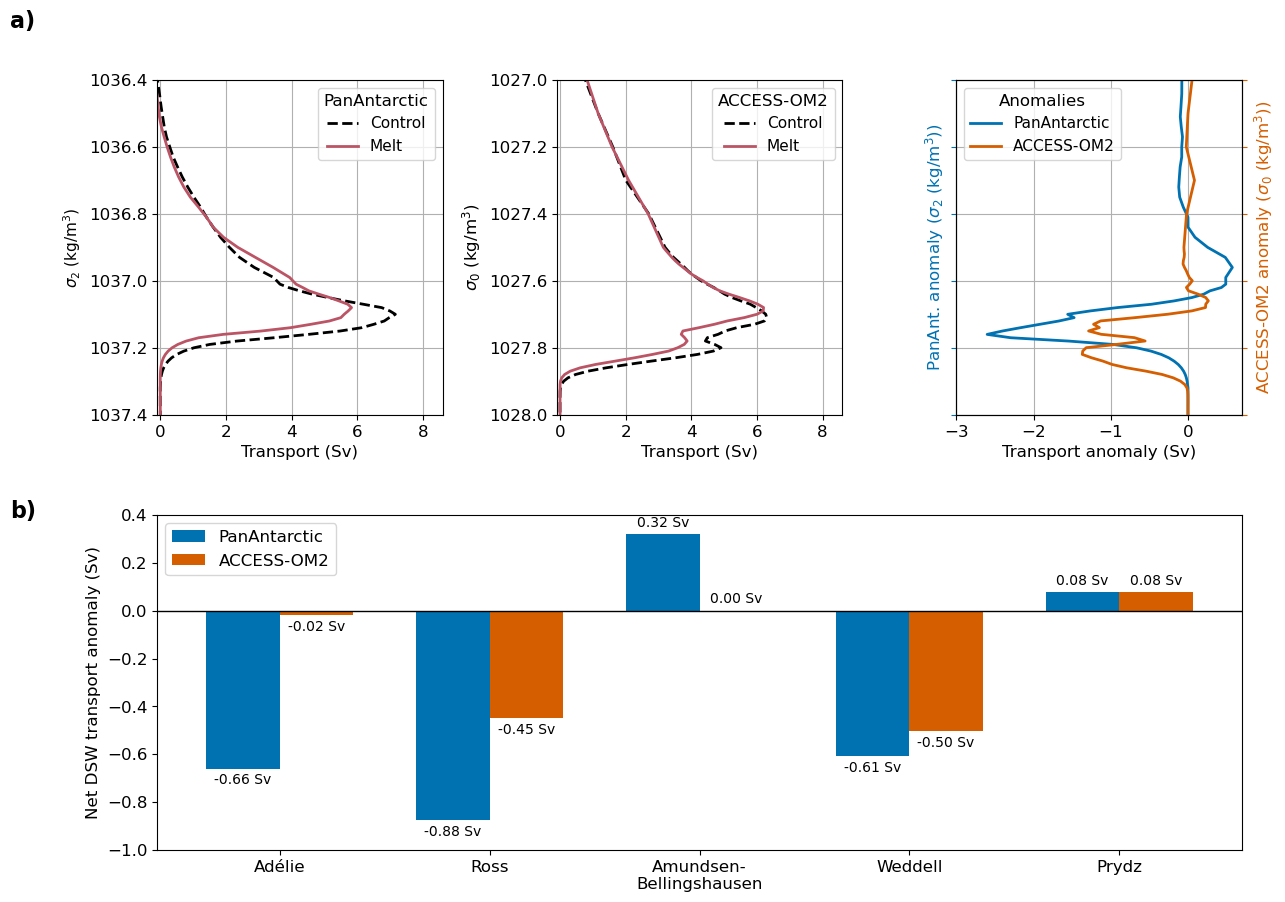

In [103]:
plt.rcParams['font.size'] = 12

# --- Define combined figure layout: 2 rows (top: 3 cols, bottom: 1 col full width) ---
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1],width_ratios=[1,1, 1],wspace=0.4, hspace=0.3)

# Pick out Circumpolar only (col=0)
name = sector_names[0]       # "Circumpolar"
letter = letter_labels[0]    # "a)"

# =====================
# Top row: 3 panels
# =====================
# --------------------
# Panel 1: pan01 (control vs melt)
ax1 = fig.add_subplot(gs[0, 0])
sector_panant_control[0].plot(ax=ax1, y='rho2_l',
                             color=colors['control'], linestyle=linestyles['control'],
                             linewidth=linewidths['control'], label=labels['control'])
sector_panant_melt[0].plot(ax=ax1, y='rho2_l',
                          color=colors['melt'], linestyle=linestyles['melt'],
                          linewidth=linewidths['melt'], label=labels['melt'])
ax1.set_ylim(1037.4, 1036.4)
ax1.set_xlim(xlims_ctrlmelt[name])
ax1.grid()
ax1.set_ylabel(r'$\sigma_2$ (kg/m$^3$)', fontsize=11)
ax1.legend(loc='upper right', fontsize=11, title="PanAntarctic")
ax1.set_xlabel("Transport (Sv)")
ax1.set_title("")
ax1.tick_params(labelleft=True)  # show y-axis numbers

# --------------------
# Panel 2: ACCESS (control vs melt)
ax2 = fig.add_subplot(gs[0, 1])
sector_access_control[0].plot(ax=ax2, y='isopycnal_bins',
                              color=colors['control'], linestyle=linestyles['control'],
                              linewidth=linewidths['control'], label=labels['control'])
sector_access_melt[0].plot(ax=ax2, y='isopycnal_bins',
                           color=colors['melt'], linestyle=linestyles['melt'],
                           linewidth=linewidths['melt'], label=labels['melt'])
ax2.set_ylim(1028, 1027)
ax2.set_xlim(xlims_ctrlmelt[name])
ax2.grid()
ax2.set_ylabel('$\sigma_0$ (kg/m$^3$)')
ax2.tick_params(labelleft=True)  # show y-axis numbers
ax2.legend(loc='upper right', fontsize=11, title="ACCESS-OM2")
ax2.set_xlabel("Transport (Sv)")
ax2.set_title("")

# --------------------
# Panel 3: anomalies
ax3 = fig.add_subplot(gs[0, 2])

# Left y-axis: PanAnt anomalies
sector_anoms_panant[0].plot(
    ax=ax3, y='rho2_l',
    color=colors['anom_pan'],
    linestyle=linestyles['anom_pan'],
    linewidth=linewidths['anom_pan'],
    label=labels['anom_pan']
)
ax3.set_ylim(1037.4, 1036.4)  # PanAnt y-lims
ax3.set_xlim(-3,0.7)
ax3.set_ylabel('PanAnt. anomaly ($\sigma_2$ (kg/m$^3$))', color=colors['anom_pan'])
ax3.tick_params(axis='y', colors=colors['anom_pan'], labelleft=False)  # ticks yes, numbers no
ax3.grid()

# Right y-axis: ACCESS anomalies
ax3b = ax3.twinx()
sector_anoms_access[0].plot(
    ax=ax3b, y='isopycnal_bins',
    color=colors['anom_acc'],
    linestyle=linestyles['anom_acc'],
    linewidth=linewidths['anom_acc'],
    label=labels['anom_acc']
)
ax3b.set_ylim(1028, 1027)  # ACCESS y-lims
ax3b.set_ylabel('ACCESS-OM2 anomaly ($\sigma_0$ (kg/m$^3$))', color=colors['anom_acc'])
ax3b.tick_params(axis='y', colors=colors['anom_acc'], labelleft=False, labelright=False)  # show ticks, hide numbers

# Shared x-axis setup
ax3.set_xlabel("Transport anomaly (Sv)", fontsize=12)

# Combine handles and labels from both axes
lines_ax3, labels_ax3 = ax3.get_legend_handles_labels()
lines_ax3b, labels_ax3b = ax3b.get_legend_handles_labels()

ax3.legend(lines_ax3 + lines_ax3b, labels_ax3 + labels_ax3b,
           loc='upper left', fontsize=11, title="Anomalies")


# =====================
# Bottom row: 1 wide bar chart
# =====================
ax4 = fig.add_subplot(gs[1, :])  # span all 3 columns

regions = list(net_panant.keys())
x = np.arange(len(regions))
bar_width = 0.35

bars1 = ax4.bar(x - bar_width/2, [net_panant[r] for r in regions], width=bar_width,
                label='PanAntarctic', color=colors['anom_pan'])
bars2 = ax4.bar(x + bar_width/2, [net_access[r] for r in regions], width=bar_width,
                label='ACCESS-OM2', color=colors['anom_acc'])

# Add labels above/below depending on sign
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height >= 0:
            va, y = 'bottom', height + 0.02
        else:
            va, y = 'top', height - 0.02
        ax4.text(bar.get_x() + bar.get_width()/2., y,
                 f'{height:.2f} Sv', ha='center', va=va, fontsize=10)

ax4.axhline(0, color='k', linewidth=1)
ax4.set_ylim(-1,0.4)
ax4.set_xticks(x)
ax4.set_xticklabels(region_labels)
ax4.set_ylabel('Net DSW transport anomaly (Sv)')
ax4.legend(loc='upper left')

# === Panel labels ===
fig.text(0.02, 0.95, "a)", fontsize=16, fontweight='bold', va="top", ha="left")
fig.text(0.02, 0.46, "b)", fontsize=16, fontweight='bold', va="top", ha="left")

# =====================
# Final layout
# =====================
plt.tight_layout()
fig.savefig("/g/data/g40/kc5856/thesis_figures/intermodel_DSWexport_combined.png",
            dpi=300, bbox_inches='tight')
plt.show()

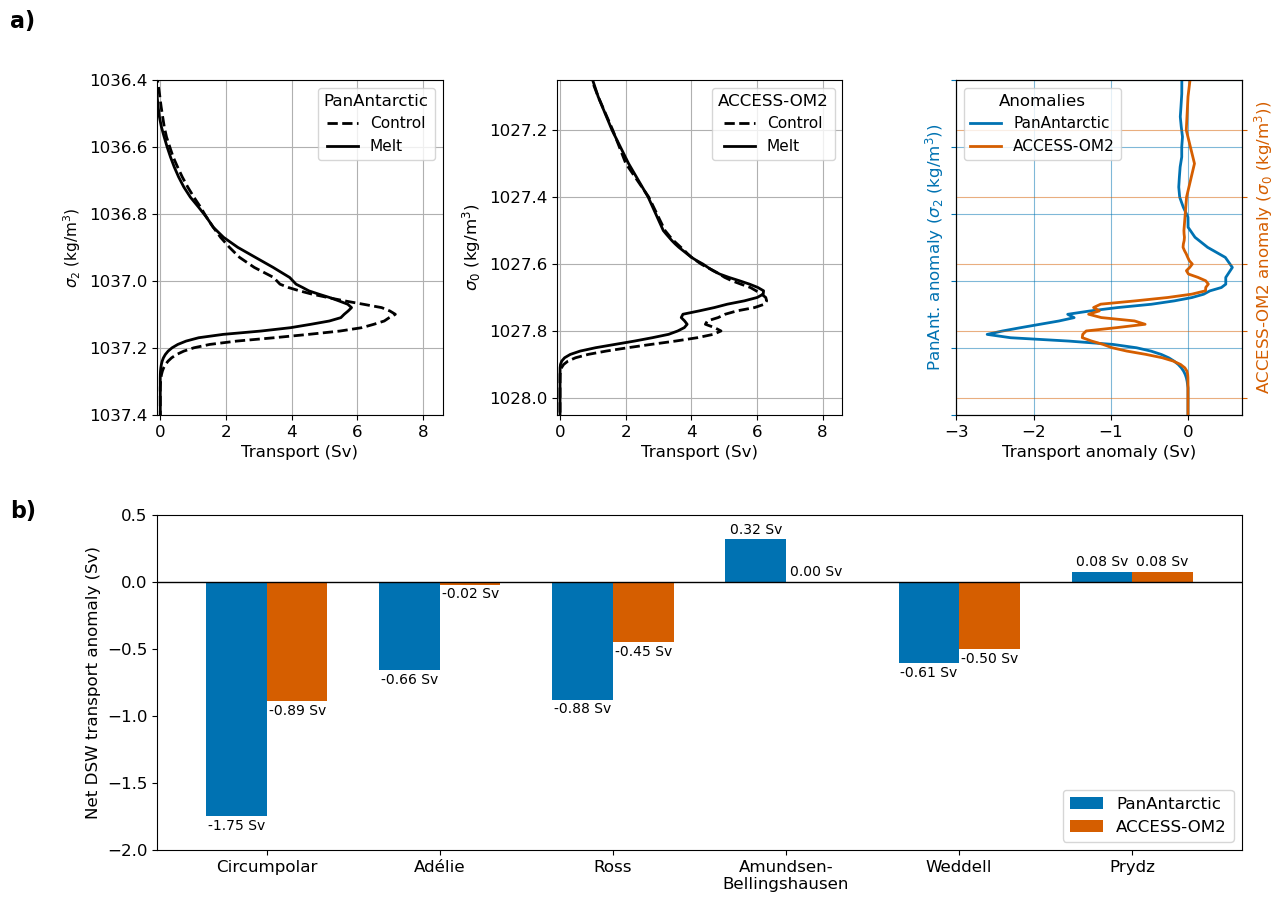

In [110]:
plt.rcParams['font.size'] = 12

# --- Define combined figure layout: 2 rows (top: 3 cols, bottom: 1 col full width) ---
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1],width_ratios=[1,1, 1],wspace=0.4, hspace=0.3)

# =====================
# Top row: 3 panels
# =====================
# --------------------
# Panel 1: pan01 (control vs melt)
ax1 = fig.add_subplot(gs[0, 0])
sector_panant_control[0].plot(ax=ax1, y='rho2_l',
                             color=colors['control'], linestyle=linestyles['control'],
                             linewidth=linewidths['control'], label=labels['control'])
sector_panant_melt[0].plot(ax=ax1, y='rho2_l',
                          color=colors['control'], linestyle=linestyles['melt'],
                          linewidth=linewidths['melt'], label=labels['melt'])
ax1.set_ylim(1037.4, 1036.4)
ax1.set_xlim(xlims_ctrlmelt[name])
ax1.grid()
ax1.set_ylabel(r'$\sigma_2$ (kg/m$^3$)', fontsize=11)
ax1.legend(loc='upper right', fontsize=11, title="PanAntarctic")
ax1.set_xlabel("Transport (Sv)")
ax1.set_title("")
ax1.tick_params(labelleft=True)  # show y-axis numbers

# --------------------
# Panel 2: ACCESS (control vs melt)
ax2 = fig.add_subplot(gs[0, 1])
sector_access_control[0].plot(ax=ax2, y='isopycnal_bins',
                              color=colors['control'], linestyle=linestyles['control'],
                              linewidth=linewidths['control'], label=labels['control'])
sector_access_melt[0].plot(ax=ax2, y='isopycnal_bins',
                           color=colors['control'], linestyle=linestyles['melt'],
                           linewidth=linewidths['melt'], label=labels['melt'])
ax2.set_ylim(1028.05, 1027.05)
ax2.set_xlim(xlims_ctrlmelt[name])
ax2.grid()
ax2.set_ylabel('$\sigma_0$ (kg/m$^3$)')
ax2.tick_params(labelleft=True)  # show y-axis numbers
ax2.legend(loc='upper right', fontsize=11, title="ACCESS-OM2")
ax2.set_xlabel("Transport (Sv)")
ax2.set_title("")

# --------------------
# Panel 3: anomalies
ax3 = fig.add_subplot(gs[0, 2])

# Left y-axis: PanAnt anomalies
sector_anoms_panant[0].plot(
    ax=ax3, y='rho2_l',
    color=colors['anom_pan'],
    linestyle=linestyles['anom_pan'],
    linewidth=linewidths['anom_pan'],
    label=labels['anom_pan']
)
ax3.set_ylim(1037.4, 1036.4)  # PanAnt y-lims
ax3.set_xlim(-3,0.7)
ax3.set_ylabel('PanAnt. anomaly ($\sigma_2$ (kg/m$^3$))', color=colors['anom_pan'])
ax3.tick_params(axis='y', colors=colors['anom_pan'], labelleft=False)  # ticks yes, numbers no
ax3.grid(color=colors['anom_pan'],alpha=0.5)

# Right y-axis: ACCESS anomalies
ax3b = ax3.twinx()
sector_anoms_access[0].plot(
    ax=ax3b, y='isopycnal_bins',
    color=colors['anom_acc'],
    linestyle=linestyles['anom_acc'],
    linewidth=linewidths['anom_acc'],
    label=labels['anom_acc']
)
ax3b.set_ylim(1028.05, 1027.05)  # ACCESS y-lims
ax3b.set_ylabel('ACCESS-OM2 anomaly ($\sigma_0$ (kg/m$^3$))', color=colors['anom_acc'])
ax3b.tick_params(axis='y', colors=colors['anom_acc'], labelleft=False, labelright=False)  # show ticks, hide numbers
ax3b.grid(color=colors['anom_acc'],alpha=0.5)


# Combine handles and labels from both axes
lines_ax3, labels_ax3 = ax3.get_legend_handles_labels()
lines_ax3b, labels_ax3b = ax3b.get_legend_handles_labels()

ax3b.legend(lines_ax3 + lines_ax3b, labels_ax3 + labels_ax3b,
           loc='upper left', fontsize=11, title="Anomalies")

# Shared x-axis setup
ax3.set_xlabel("Transport anomaly (Sv)", fontsize=12)


# =====================
# Bottom row: 1 wide bar chart
# =====================
ax4 = fig.add_subplot(gs[1, :])  # span all 3 columns

# Compute circumpolar net transport (sum of all regions)
circ_panant = sum(net_panant.values())
circ_access = sum(net_access.values())

# Include circumpolar as first "region"
regions_with_circ = ['Circumpolar'] + list(net_panant.keys())
panant_vals = [circ_panant] + [net_panant[r] for r in net_panant]
access_vals = [circ_access] + [net_access[r] for r in net_access]

x = np.arange(len(regions_with_circ))
bar_width = 0.35

bars1 = ax4.bar(x - bar_width/2, panant_vals, width=bar_width,
                label='PanAntarctic', color=colors['anom_pan'])
bars2 = ax4.bar(x + bar_width/2, access_vals, width=bar_width,
                label='ACCESS-OM2', color=colors['anom_acc'])

# Add labels above/below depending on sign
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height >= 0:
            va, y = 'bottom', height + 0.02
        else:
            va, y = 'top', height - 0.02
        ax4.text(bar.get_x() + bar.get_width()/2., y,
                 f'{height:.2f} Sv', ha='center', va=va, fontsize=10)

ax4.axhline(0, color='k', linewidth=1)
ax4.set_ylim(-2, 0.5)
ax4.set_xticks(x)
ax4.set_xticklabels(['Circumpolar'] + region_labels)
ax4.set_ylabel('Net DSW transport anomaly (Sv)')
ax4.legend(loc='lower right')

# === Panel labels ===
fig.text(0.02, 0.95, "a)", fontsize=16, fontweight='bold', va="top", ha="left")
fig.text(0.02, 0.46, "b)", fontsize=16, fontweight='bold', va="top", ha="left")

# =====================
# Final layout
# =====================
plt.tight_layout()
fig.savefig("/g/data/g40/kc5856/thesis_figures/intermodel_DSWexport_combined_circ.png",
            dpi=300, bbox_inches='tight')
plt.show()